In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

In [14]:
data = pd.read_csv('../datasets/train.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [15]:
data.dtypes

Store             int64
Dept              int64
Weekly_Sales    float64
IsHoliday          bool
dtype: object

* Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store.

In [16]:
store1 = data[data.Store==1]
store1.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [17]:
store1.dtypes

Store             int64
Dept              int64
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [27]:
store1_totals = store1['Weekly_Sales'].resample('W').sum()
# same as below for timeseries
# store1.groupby(store1.index)['Weekly_Sales'].sum().head()
store1_totals.head()

Date
2010-02-07    1643690.90
2010-02-14    1641957.44
2010-02-21    1611968.17
2010-02-28    1409727.59
2010-03-07    1554806.68
Freq: W-SUN, Name: Weekly_Sales, dtype: float64

* Plot the rolling_mean for Weekly_Sales. What general trends do you observe?

In [28]:
print store1_totals.index.min()
print store1_totals.index.max()

2010-02-07 00:00:00
2012-10-28 00:00:00


In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

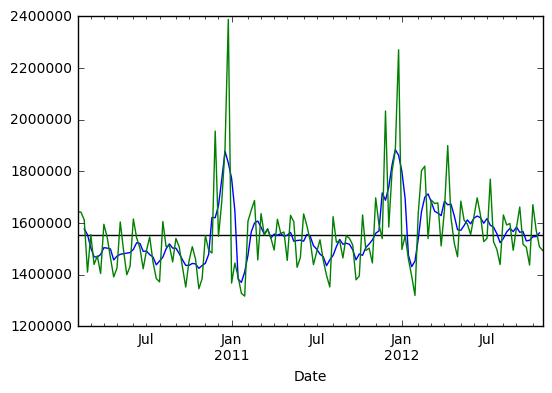

In [38]:
# store1_totals.rolling(1, center=True).mean().plot()
# store1_totals.rolling(2, center=True).mean().plot()
store1_totals.rolling(4, center=True).mean().plot()
# store1_totals.rolling(12, center=True).mean().plot()
store1_totals.plot()
plt.hlines(store1_totals.mean(), store1_totals.index.min(), store1_totals.index.max())

* Compute the 1, 2, 52 autocorrelations for Weekly_Sales and/or create an autocorrelation plot.

In [41]:
print store1_totals.autocorr(1)
print store1_totals.autocorr(2)
print store1_totals.autocorr(4)
print store1_totals.autocorr(52)

0.302158279411
0.127413130554
0.238192940883
0.895376029478


* What does the autocorrelation plot say about the type of model you want to build?

In [42]:
from pandas.tools.plotting import autocorrelation_plot

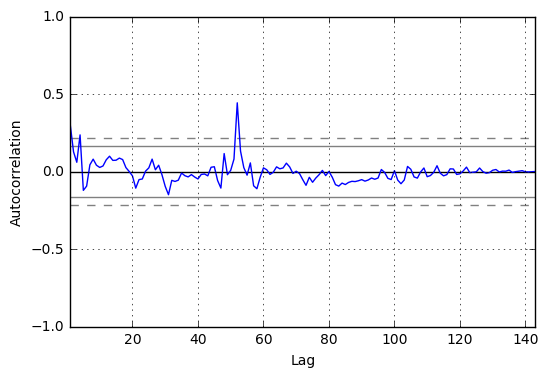

In [43]:
autocorrelation_plot(store1_totals)

* Split the weekly sales data in a training and test set - using 75% of the data for training

In [44]:
store1_totals.tail()

Date
2012-09-30    1437059.26
2012-10-07    1670785.97
2012-10-14    1573072.81
2012-10-21    1508068.77
2012-10-28    1493659.74
Freq: W-SUN, Name: Weekly_Sales, dtype: float64

In [45]:
print(.75*len(store1_totals))

107.25


In [74]:
train = store1_totals.iloc[0:108]
len(train)

108

In [75]:
test = store1_totals.iloc[108:]
len(test)

35

* Create an AR(1) model on the training data and compute the mean absolute error of the predictions. How effective is this model?

In [52]:
import math

In [56]:
def mean_absolute_error(prediction, actual):
    vals = []
    for x in range(0, len(actual)):
        vals.append(math.fabs(prediction[x] - actual[x]))
    numerator = sum(vals)
    denominator = len(actual)
    return numerator / float(denominator)

In [57]:
mean_absolute_error([1, 1, 1], [0, 1, 0])

0.6666666666666666

In [58]:
from statsmodels.tsa.arima_model import ARMA

In [90]:
model = ARMA(train,(1, 0)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  108
Model:                     ARMA(1, 0)   Log Likelihood               -1447.727
Method:                       css-mle   S.D. of innovations         160409.075
Date:                Wed, 30 Nov 2016   AIC                           2901.454
Time:                        12:37:20   BIC                           2909.500
Sample:                    02-07-2010   HQIC                          2904.716
                         - 02-26-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const               1.544e+06   2.22e+04     69.636      0.000       1.5e+06  1.59e+06
ar.L1.Weekly_Sales     0.3066      0.091      3.363      0.001         0.128     0.485
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.2621           +0.0000j            3.2621            0.0000
-----------------------------------------------------------------------------
"""

In [93]:
predictions = model.predict

In [94]:
predictions = model.predict(108, 108+35)

In [95]:
mean_absolute_error(predictions.values, test.values)

82721.31038707652

* Plot the residuals - where are their significant errors?

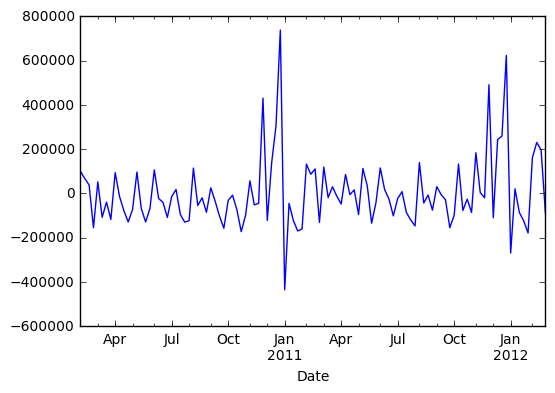

In [96]:
model.resid.plot()

* Compute and AR(2) model and an ARMA(2, 2) model - does this improve your mean absolute error on the held out set?

In [107]:
model = ARMA(train, (2, 2)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  108
Model:                     ARMA(2, 2)   Log Likelihood               -1438.590
Method:                       css-mle   S.D. of innovations         143458.073
Date:                Wed, 30 Nov 2016   AIC                           2889.180
Time:                        12:40:07   BIC                           2905.272
Sample:                    02-07-2010   HQIC                          2895.705
                         - 02-26-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const               1.544e+06    1.9e+04     81.070      0.000      1.51e+06  1.58e+06
ar.L1.Weekly_Sales    -1.0397      0.089    -11.636      0.000        -1.215    -0.865
ar.L2.Weekly_Sales    -0.4700      0.087     -5.404      0.000        -0.641    -0.300
ma.L1.Weekly_Sales     1.4689      0.056     26.270      0.000         1.359     1.578
ma.L2.Weekly_Sales     0.9997      0.071     14.092      0.000         0.861     1.139
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1060           -0.9510j            1.4586           -0.3870
AR.2           -1.1060           +0.9510j            1.4586            0.3870
MA.1           -0.7347           -0.6787j            1.0002           -0.3813
MA.2           -0.7347           +0.6787j            1.0002            0.3813
-----------------------------------------------------------------------------
"""

In [108]:
predictions = model.predict(108, 108+35)
mean_absolute_error(predictions.values, test.values)

82167.08596050952

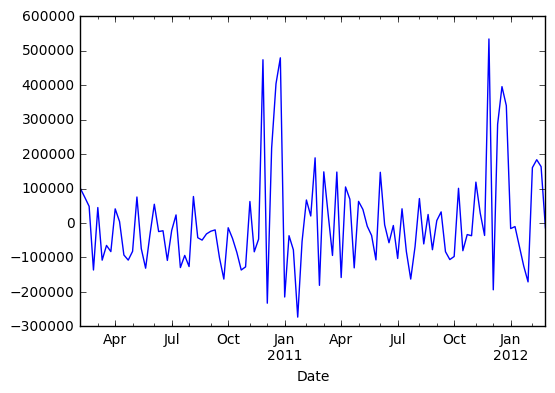

In [109]:
model.resid.plot()

* Finally, compute an ARIMA model to improve your prediction error - iterate on the p, q, and parameters comparing the model's performance

In [110]:
from statsmodels.tsa.arima_model import ARIMA

In [111]:
model = ARIMA(train, (2, 1, 1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.Weekly_Sales   No. Observations:                  107
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1435.456
Method:                       css-mle   S.D. of innovations         159165.102
Date:                Wed, 30 Nov 2016   AIC                           2880.912
Time:                        12:40:11   BIC                           2894.276
Sample:                    02-14-2010   HQIC                          2886.329
                         - 02-26-2012                                         
========================================================================================
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                 1108.8919    704.332      1.574      0.118      -271.574  2489.357
ar.L1.D.Weekly_Sales     0.2739      0.097      2.819      0.006         0.083     0.464
ar.L2.D.Weekly_Sales     0.0378      0.098      0.386      0.701        -0.154     0.230
ma.L1.D.Weekly_Sales    -1.0000      0.027    -37.442      0.000        -1.052    -0.948
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.6681           +0.0000j            2.6681            0.0000
AR.2           -9.9156           +0.0000j            9.9156            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [113]:
predictions = model.predict(108, 108+34)
mean_absolute_error(predictions.values, test.values)

1587870.3777613952

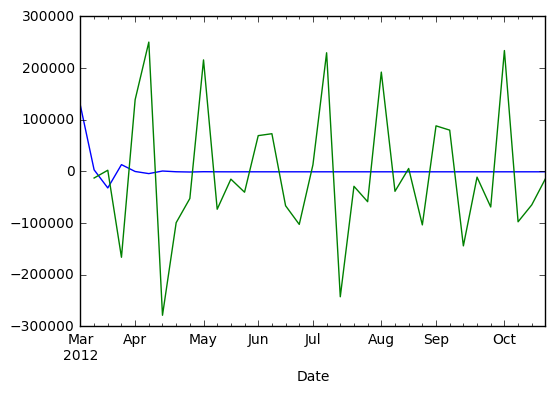

In [127]:
model = ARIMA(train, (2, 1, 0)).fit()
predictions = model.predict(108, 108+34)
predictions.plot()
test.diff(1).plot()